In [1]:
from sklearn.metrics import mean_squared_error as MSE
from common import *
from models import *

In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")
print(df.shape)

(51648, 20)


In [3]:
days = seperate_column_to_days(df['NO2_price'])


# Creating datasets of days
What I want is to create individual sequences of days, the idea is to use 72 hours to create 3 days, which can then be used to predict further on in time

In [4]:
lookbehind = 3
horizon = 24
no_hours = lookbehind*24 + horizon# lookbehind + one horizon
hour_in_days = int(no_hours / 24)

dataset = []
for i in range(len(days)-hour_in_days+1):
    dataset.append(np.concatenate((days[i:i+hour_in_days])))

dataset = np.array(dataset)

In [5]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
dataset = dataset[..., np.newaxis].astype(np.float32)

n,m,k = dataset.shape
print(n,m,k)

n_steps = m - 24
horizon = 24

2145 192 1


In [6]:
train = int(0.7*n)
valid = int(0.9*n)
#train = int(0.9*n)

# (7000 time series, 50 steps each)
X_train, y_train = dataset[:train, :n_steps], dataset[:train, -horizon:, 0]
X_valid, y_valid = dataset[train:valid, :n_steps], dataset[train:valid, -horizon: 0]
X_test, y_test = dataset[valid:, :n_steps], dataset[valid:, -horizon:, 0]
#X_test, y_test = dataset[train:, :n_steps], dataset[train:, -horizon:, 0]


# Seq - to - seq does not give satisfying results

Y = np.empty((n, n_steps, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset[:,step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]


print(f"{X_train.shape=}")
print(f"{X_valid.shape=}")
print(f"{X_test.shape=}")

X_train.shape=(1501, 168, 1)
X_valid.shape=(429, 168, 1)
X_test.shape=(215, 168, 1)


In [7]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(horizon)
])


model_ln = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20)),
    keras.layers.Dense(horizon)
])

model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(horizon)
])

"""
model_gru = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])
"""

'\nmodel_gru = keras.models.Sequential([\n    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),\n    keras.layers.GRU(20, return_sequences=True),\n    keras.layers.TimeDistributed(keras.layers.Dense(horizon))\n])\n'

In [8]:
model.summary()
model_ln.summary()
model_lstm.summary()
#model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 24)                504       
                                                                 
Total params: 1,764
Trainable params: 1,764
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, None, 20)          480       
                                                                 
 rnn_1 (RNN)                 (No

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 5
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_ln.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_lstm.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
#model_gru.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [10]:
batch_size = 1000

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)#, validation_data=(X_valid, y_valid))

Epoch 1/5
2/2 [==============================] - 4s 580ms/step - loss: 0.1072 - last_time_step_mse: 0.3511
Epoch 2/5
2/2 [==============================] - 1s 584ms/step - loss: 0.0701 - last_time_step_mse: 0.1674
Epoch 3/5
2/2 [==============================] - 1s 588ms/step - loss: 0.0472 - last_time_step_mse: 0.0919
Epoch 4/5
2/2 [==============================] - 1s 584ms/step - loss: 0.0175 - last_time_step_mse: 0.1431
Epoch 5/5
2/2 [==============================] - 1s 604ms/step - loss: 0.0127 - last_time_step_mse: 0.1580


In [11]:
history_ln = model_ln.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)#, validation_data=(X_valid, y_valid))

Epoch 1/5
2/2 [==============================] - 5s 1s/step - loss: 0.3779 - last_time_step_mse: 0.5113
Epoch 2/5
2/2 [==============================] - 2s 1s/step - loss: 0.3203 - last_time_step_mse: 0.3637
Epoch 3/5
2/2 [==============================] - 2s 1s/step - loss: 0.2135 - last_time_step_mse: 0.5054
Epoch 4/5
2/2 [==============================] - 2s 1s/step - loss: 0.1507 - last_time_step_mse: 0.1502
Epoch 5/5
2/2 [==============================] - 2s 1s/step - loss: 0.1764 - last_time_step_mse: 0.6063


In [12]:
history_lstm = model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)#, validation_data=(X_valid, y_valid))

Epoch 1/5
2/2 [==============================] - 7s 21ms/step - loss: 0.0478 - last_time_step_mse: 0.1843
Epoch 2/5
2/2 [==============================] - 0s 24ms/step - loss: 0.0300 - last_time_step_mse: 0.1988
Epoch 3/5
2/2 [==============================] - 0s 73ms/step - loss: 0.0130 - last_time_step_mse: 0.1470
Epoch 4/5
2/2 [==============================] - 0s 50ms/step - loss: 0.0044 - last_time_step_mse: 0.0466
Epoch 5/5
2/2 [==============================] - 0s 32ms/step - loss: 0.0057 - last_time_step_mse: 0.0414


In [13]:
#history_gru = model_gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

In [14]:
Y_pred = model.predict(X_test)

In [15]:
Y_pred_ln = model_ln.predict(X_test)

In [16]:
Y_pred_lstm = model_lstm.predict(X_test)

# Sequence to vector, with 24 outputs at final timestep

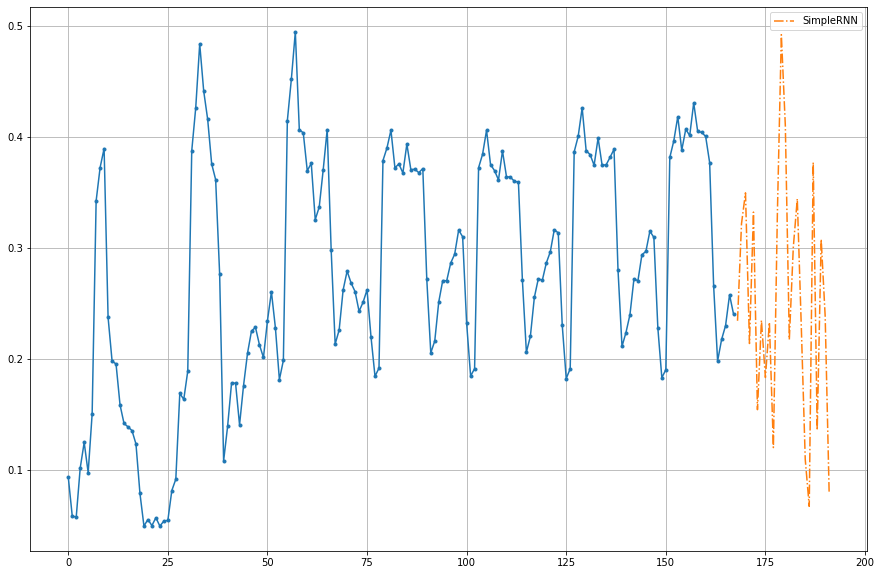

In [17]:
x = np.arange(no_hours)
plt.figure(figsize=(15,10))
plt.plot(x[:no_hours-horizon], X_test[36,:].flatten(), '.-')
plt.plot(x[-horizon:], Y_pred[36].flatten(), '-.', label="SimpleRNN")
#plt.plot(x[-horizon:], Y_pred_ln[36].flatten(), '-.', label="LayerNorm")
#plt.plot(x[-horizon:], Y_pred_lstm[36].flatten(), '-.', label="LSTM")
plt.legend()
plt.grid()
plt.show()

# SEQ to SEQ plots
These are now corrected

In [18]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(32, return_sequences=True),
    #keras.layers.SimpleRNN(32, return_sequences=True),
    #keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.Dense(horizon)#, activation='leaky_relu')
])

model_lstm = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    #keras.layers.LSTM(32, return_sequences=True),
    #keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dense(horizon)#, activation='leaky_relu')
])

model_gru = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.GRU(32, return_sequences=True),
    #keras.layers.GRU(32, return_sequences=True),
    #keras.layers.GRU(64, return_sequences=True),
    keras.layers.Dense(horizon)#, activation='leaky_relu')
])

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 25
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_lstm.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_gru.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [20]:
model.summary()
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 64)          4224      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          3104      
                                                                 
 dense_3 (Dense)             (None, None, 24)          792       
                                                                 
Total params: 8,120
Trainable params: 8,120
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 64)          16896     
                                                                 
 lstm_3 (LSTM)               (

In [22]:

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, Y_valid))

Epoch 1/25
2/2 [==============================] - 3s 2s/step - loss: 0.0021 - last_time_step_mse: 0.0342 - val_loss: 0.0020 - val_last_time_step_mse: 0.0264
Epoch 2/25
2/2 [==============================] - 3s 2s/step - loss: 0.0020 - last_time_step_mse: 0.0332 - val_loss: 0.0020 - val_last_time_step_mse: 0.0268
Epoch 3/25
2/2 [==============================] - 3s 2s/step - loss: 0.0020 - last_time_step_mse: 0.0336 - val_loss: 0.0019 - val_last_time_step_mse: 0.0257
Epoch 4/25
2/2 [==============================] - 3s 2s/step - loss: 0.0020 - last_time_step_mse: 0.0330 - val_loss: 0.0019 - val_last_time_step_mse: 0.0255
Epoch 5/25
2/2 [==============================] - 3s 2s/step - loss: 0.0019 - last_time_step_mse: 0.0328 - val_loss: 0.0019 - val_last_time_step_mse: 0.0253
Epoch 6/25
2/2 [==============================] - 3s 2s/step - loss: 0.0019 - last_time_step_mse: 0.0331 - val_loss: 0.0019 - val_last_time_step_mse: 0.0244
Epoch 7/25
2/2 [==============================] - 3s 2s/st

In [23]:
history_lstm = model_lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/25


KeyboardInterrupt: 

In [24]:
history_gru = model_gru.fit(X_train, Y_train[:,3::2], epochs=epochs, batch_size=batch_size, validation_data=(X_valid, Y_valid[:,3::2]))

Epoch 1/25


In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

In [ ]:
pd.DataFrame(history_lstm.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

In [ ]:
pd.DataFrame(history_gru.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_lstm = model_lstm.predict(X_test)
Y_pred_gru = model_gru.predict(X_test)

In [ ]:
print(f"{MSE(Y_test[36,-1], Y_pred[36,-1])=}")
print(f"{MSE(Y_test[36,-1], Y_pred_lstm[36,-1])=}")
print(f"{MSE(Y_test[36,-1], Y_pred_gru[36,-1])=}")

In [ ]:
x = np.arange(no_hours)
plt.figure(figsize=(30,15))
plt.plot(x[:no_hours-horizon], X_test[36,:].flatten(), '.-')
plt.plot(x[-horizon:], Y_test[test_sample[0],-1].flatten(), '.-', label="True Solution")
plt.plot(x[-horizon:], Y_pred[test_sample[0],-1].flatten(), '-.', label="SimpleRNN")
plt.plot(x[-horizon:], Y_pred_lstm[36,-1].flatten(), '-.', label="LSTM")
plt.plot(x[-horizon:], Y_pred_gru[36,-1].flatten(), '-.', label="GRU")
plt.legend()
plt.grid()
plt.show()

In [ ]:
"""
Y_pred = model.predict(X_test)
Y_pred_ln = model_ln.predict(X_test)
Y_pred_lstm = model_lstm.predict(X_test)
#Y_pred_gru = model_gru.predict(X_test)
"""

In [ ]:
"""
sequence = np.concatenate((X_test[0].flatten(), Y_pred[0,-1,:].flatten()))
sequence_ln = np.concatenate((X_test[0].flatten(), Y_pred_ln[0,-1,:].flatten()))
sequence_lstm = np.concatenate((X_test[0].flatten(), Y_pred_lstm[0,-1,:].flatten()))
#sequence_gru = np.concatenate((X_test[20].flatten(), Y_pred_gru[20,-horizon:,-1].flatten()))

x = np.arange(n_steps + horizon)
plt.figure(figsize=(15,10))
plt.plot(x[:n_steps], sequence[:n_steps], '.-')
plt.plot(x[n_steps-1:], sequence[n_steps-1:], '-.', label="SimpleRNN")
plt.plot(x[n_steps-1:], sequence_ln[n_steps-1:], '-.', label="Layer norm")
plt.plot(x[n_steps-1:], sequence_lstm[n_steps-1:], '-.', label="LSTM")
#plt.plot(x[n_steps-1:], sequence_gru[n_steps-1:], '-.', label="GRU")

plt.legend()
plt.grid()
plt.show()
"""

In [ ]:
"""
fig = plt.figure()
x = np.arange(5*24)
plt.plot(x[:72],dataset[0],'--')
plt.plot(x[24:4*24],dataset[1],'--')
plt.plot(x[2*24:5*24],dataset[2],'--')
plt.xlabel("time")
plt.ylabel("price")
plt.grid()
plt.show
"""